In [ ]:
# pip install pingouin

In [46]:
# import necessary packages

import pandas as pd
import itertools
import numpy as np
# import scipy.stats
from statsmodels.stats.weightstats import ztest as ztest
import time

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import networkx as nx
from random import randint

import math
# import pingouin as pg

import warnings
warnings.filterwarnings("ignore")

In [17]:
# import necessary data

# result = pd.read_csv("/Users/robinkong/codes/result.csv")
# paperdata = pd.read_csv("/Users/robinkong/codes/paperdata.csv")
cb = pd.read_csv("/Users/robinkong/codes/citationBara.csv")
primdata = pd.read_csv("/Users/robinkong/codes/primdata.csv")
pair = pd.read_csv("/Users/robinkong/codes/pairs.csv", chunksize = 1000000)
# mfpairs = pd.read_csv("/Users/robinkong/codes/mfpairs.csv")
# sim_mf = pd.read_csv("/Users/robinkong/codes/mfpairs_similarity.csv")

In [3]:
# DataFrame: {citing_doi, citing_year, cited_doi}

citinfo = primdata[["doi", "year"]].drop_duplicates(subset = 'doi')
cols = ['citing_doi', 'citing_year', 'cited_doi']

citinfo = citinfo.merge(cb, left_on = 'doi', right_on = 'citing_doi',
              how = 'inner').drop(['doi'], axis=1).rename(
                  {'year': 'citing_year'}, axis=1).reindex(
                      columns=cols).sort_values('cited_doi')

citinfo.head()

,citing_doi,citing_year,cited_doi
120140,10.1103/PhysRev.2.109,1913,10.1103/PhysRev.1.124
123113,10.1103/PhysRev.40.281,1932,10.1103/PhysRev.1.124
120191,10.1103/PhysRev.21.250,1923,10.1103/PhysRev.1.124
144119,10.1103/PhysRev.8.738,1916,10.1103/PhysRev.1.124
2740023,10.1103/PhysRevSeriesI.2.1,1894,10.1103/PhysRev.1.2


# Basic Statistics

In [144]:
print("Total papers: ", result.doi.nunique())
print("Papers with gender info: ", paperdata.doi.nunique())
print("Papers with primary gender info: ", primdata.doi.nunique())

Total papers:  541448
Papers with gender info:  375738
Papers with primary gender info:  273020


In [145]:
# journal query condition

s = "PRL"

print(f"Total {s} papers: ", result[result['journal'] == s].doi.nunique())
print(f"{s} papers with gender info: ", paperdata[paperdata['journal'] == s].doi.nunique())

df = primdata[primdata['journal'] == s]

print(f"{s} papers with primary gender info: ", df.doi.nunique())
print(f"{s} papers written primarily by men: ", len(df[df['gender']=='male']))
print(f"{s} papers written primarily by women: ", len(df[df['gender']=='female']))

Total PRL papers:  110080
PRL papers with gender info:  76527
PRL papers with primary gender info:  54460
PRL papers written primarily by men:  48950
PRL papers written primarily by women:  5510


In [156]:
# PACS query condition

pacs = '90'

print(f"Total PACS{pacs} papers: ", result[result[f'pacs{pacs}'] == 1].doi.nunique())
print(f"PACS{pacs} papers with gender info: ", paperdata[paperdata[f'pacs{pacs}'] == 1].doi.nunique())

df = primdata[primdata[f'pacs{pacs}'] == 1]

print(f"PACS{pacs} papers with primary gender info: ", df.doi.nunique())
print(f"PACS{pacs} papers written primarily by men: ", len(df[df['gender']=='male']))
print(f"PACS{pacs} papers written primarily by women: ", len(df[df['gender']=='female']))

Total PACS90 papers:  26601
PACS90 papers with gender info:  12628
PACS90 papers with primary gender info:  9597
PACS90 papers written primarily by men:  8469
PACS90 papers written primarily by women:  1128


# Pair matching

## Preparing m-w similar pairs

In [18]:
# dealing with massive pair dataFrame

pair = list(pair)
mfpairs = pd.DataFrame(columns=list(pair[0].columns))

KeyboardInterrupt: 

In [33]:
# choosing pairs where one primary author is woman and the other is man

for p in tqdm(pair):
    mfpairs = pd.concat([mfpairs, p[p['gender1'] != p['gender2']]])

100%|██████████| 69/69 [31:34<00:00, 27.46s/it]


In [58]:
mfpairs = mfpairs.drop_duplicates().reset_index(drop=True)
print(len(mfpairs))

mfpairs.to_csv(f'/Users/robinkong/codes/mfpairs.csv',index=False)

14490273


In [59]:
len(mfpairs[mfpairs['qval']<0.002])/len(mfpairs)

0.10173576439864176

## Preparing m-m similar pairs

In [19]:
# dealing with massive pair dataFrame

pair = list(pair)
mmpairs = pd.DataFrame(columns=list(pair[0].columns))

In [ ]:
# choosing pairs where both primary authors are men

for p in tqdm(pair):
    mmpairs = pd.concat([mmpairs, p[(p.gender1 == 'male') & (p.gender2 == 'male')]])

 54%|█████▎    | 37/69 [37:59<1:12:04, 135.13s/it]

In [ ]:
mmpairs = mmpairs.drop_duplicates().reset_index(drop=True)
print(len(mmpairs))

mmpairs.to_csv(f'/Users/robinkong/codes/mmpairs.csv',index=False)

## Preparing w-w similar pairs

In [5]:
# dealing with massive pair dataFrame

pair = list(pair)
wwpairs = pd.DataFrame(columns=list(pair[0].columns))

In [7]:
# choosing pairs where both primary authors are men

for p in tqdm(pair):
    wwpairs = pd.concat([wwpairs, p[(p.gender1 == 'female') & (p.gender2 == 'female')]])

100%|██████████| 65/65 [01:20<00:00,  1.24s/it]


In [8]:
wwpairs = wwpairs.drop_duplicates().reset_index(drop=True)
print(len(wwpairs))

wwpairs.to_csv(f'/Users/robinkong/codes/wwpairs.csv',index=False)

1039037


## Counting for each similar pair (m-w pairs)

In [5]:
sim_mf = mfpairs[['paper1', 'paper2', 'gender1', 'gender2', 'year1', 'year2', 'keyval', 'qval']]

In [ ]:
# Create a dummy data (test1, test2) to perform SQL:
# Create a DataFrame that treats citation info for male and female papers
test1 = sim_mf.merge(citinfo, left_on = 'paper1',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper1', 'citing_doi'])
test1['count'] = test1.groupby(['paper1'])['paper1'].transform('count')
test1 = test1.drop(["citing_doi"], axis=1).rename({'count': 'count1'}, axis=1)

test1 = test1.drop_duplicates(subset=['paper1', 'paper2'])[['paper1', 'count1']]
sim_mf = sim_mf.merge(test1, on='paper1', how='inner')

test2 = sim_mf.merge(citinfo, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test2['count'] = test2.groupby(['paper2'])['paper2'].transform('count')
test2 = test2.drop(["citing_doi"], axis=1).rename(
    {'count': 'count2'}, axis=1).drop_duplicates(
        subset=['paper1', 'paper2'])[['paper2', 'count2']]
sim_mf = sim_mf.merge(test2, on='paper2', how='inner')

# Delete the dummy data
del test1
del test2

In [22]:
# Calculate year & centrality difference among pairs

listd = []
listy = []

for c in range(len(sim_mf)):
    if sim_mf['gender1'][c] == 'male':
        listd.append(sim_mf['count1'][c] - sim_mf['count2'][c])
        listy.append(sim_mf['year1'][c] - sim_mf['year2'][c])
    else:
        listd.append(sim_mf['count2'][c] - sim_mf['count1'][c])
        listy.append(sim_mf['year2'][c] - sim_mf['year1'][c])

sim_mf['countd'] = listd
sim_mf['yeard'] = listy

# Keep the minimum q-value per pair
sim_mf = sim_mf.sort_values('qval').drop_duplicates(
    subset=['paper1', 'paper2'], keep='first')

100%|██████████| 14490273/14490273 [10:25<00:00, 23159.47it/s]


In [38]:
sim_mf.to_csv("/Users/robinkong/codes/mfpairs_similarity.csv", index=False)

## Counting for each similar pair (w-w pairs)

In [10]:
sim_ww = wwpairs[['paper1', 'paper2', 'gender1', 'gender2', 'year1', 'year2', 'keyval', 'qval']]

In [11]:
# Create a dummy data (test1, test2) to perform SQL:
# Create a DataFrame that treats citation info for male and female papers
test1 = sim_ww.merge(citinfo, left_on = 'paper1',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper1', 'citing_doi'])
test1['count'] = test1.groupby(['paper1'])['paper1'].transform('count')
test1 = test1.drop(["citing_doi"], axis=1).rename({'count': 'count1'}, axis=1)

test1 = test1.drop_duplicates(subset=['paper1', 'paper2'])[['paper1', 'count1']]
sim_ww = sim_ww.merge(test1, on='paper1', how='inner')

test2 = sim_ww.merge(citinfo, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test2['count'] = test2.groupby(['paper2'])['paper2'].transform('count')
test2 = test2.drop(["citing_doi"], axis=1).rename(
    {'count': 'count2'}, axis=1).drop_duplicates(
        subset=['paper1', 'paper2'])[['paper2', 'count2']]
sim_ww = sim_ww.merge(test2, on='paper2', how='inner')

# Delete the dummy data
del test1
del test2

In [13]:
# Calculate year & centrality difference among pairs

listd = []
listy = []

for c in tqdm(range(len(sim_ww))):
    if sim_ww['gender1'][c] == 'male':
        listd.append(sim_ww['count1'][c] - sim_ww['count2'][c])
        listy.append(sim_ww['year1'][c] - sim_ww['year2'][c])
    else:
        listd.append(sim_ww['count2'][c] - sim_ww['count1'][c])
        listy.append(sim_ww['year2'][c] - sim_ww['year1'][c])

sim_ww['countd'] = listd
sim_ww['yeard'] = listy

# Keep the minimum q-value per pair
sim_ww = sim_ww.sort_values('qval').drop_duplicates(
    subset=['paper1', 'paper2'], keep='first')

100%|██████████| 1039037/1039037 [00:40<00:00, 25500.71it/s]


In [15]:
sim_ww.to_csv("/Users/robinkong/codes/wwpairs_similarity.csv", index=False)

# Similarity Analysis

In [76]:
# filter conditions

# sdoi = primdata[primdata['journal'] == "PRL"].doi
# sdoi = primdata[primdata['pacs90'] == 1].doi

df = sim_mf.copy()

# df = df[df['paper1'].isin(sdoi)]
# df = df[df['paper2'].isin(sdoi)].reset_index(drop=True)

In [ ]:
# filter year constraints

N = 3

df = df[df['yeard'] >= -N]
df = df[df['yeard'] <= N].reset_index(drop=True)

In [77]:
p = 0.001
df_vld = df[df['qval'] < p]

print("N: ", len(df))
print("M: ", len(df_vld))
print("M/N: ", len(df_vld)/len(df))

N:  2730100
M:  410418
M/N:  0.15033075711512398


In [78]:
# getting mlist and fmlist (count per gender)

mlist = []
fmlist = []

for i in tqdm(range(len(df_vld))):
    if df_vld['gender1'][i] == 'male':
        mlist.append(df_vld['count1'][i])
        fmlist.append(df_vld['count2'][i])
    else:
        mlist.append(df_vld['count2'][i])
        fmlist.append(df_vld['count1'][i])

# Find z-scores (for p-values)
ztest(mlist, fmlist, value=0)

100%|██████████| 410418/410418 [00:04<00:00, 95449.02it/s]


(19.150151095942956, 9.65063481804804e-82)

In [ ]:
# Find z-scores (for p-values)
print(ztest(mlist, fmlist, value=0))
print('')

# Find effect size
print(pg.compute_effsize(mlist, fmlist, paired=True, eftype='hedges'))

# Centrality Difference Trend by Year (m-f pairs)

In [2]:
sim_mf = pd.read_csv("/Users/robinkong/codes/mfpairs_similarity.csv")
sim_mf.head()

,paper1,paper2,gender1,gender2,year1,year2,keyval,qval,count1,count2,countd,yeard
0,10.1103/PhysRevB.74.035411,10.1103/PhysRevB.75.205440,female,male,2006,2007,4,-1.117244e-10,1,1,0,1
1,10.1103/PhysRevB.73.075112,10.1103/PhysRevB.74.045113,female,male,2006,2006,4,-1.117173e-10,9,2,-7,0
2,10.1103/PhysRev.88.1109,10.1103/RevModPhys.24.321,male,female,1952,1952,2,-9.355250e-11,45,79,-34,0
3,10.1103/PhysRevE.70.011103,10.1103/PhysRevE.70.056128,male,female,2004,2004,3,-8.545054e-11,1,1,0,0
4,10.1103/PhysRevB.76.174508,10.1103/PhysRevLett.99.087001,male,female,2007,2007,3,-8.545054e-11,1,3,-2,0


In [3]:
mfs = sim_mf[sim_mf['yeard'] <= 3]
mfs = mfs[mfs['yeard'] >= -3].reset_index(drop=True)

lateryear = []

for i in tqdm(range(len(mfs))):
    lateryear.append(max(mfs['year1'][i], mfs['year2'][i]))

mfs['lateryear'] = lateryear

mfs.head()

100%|██████████| 5611686/5611686 [00:36<00:00, 153994.48it/s]


,paper1,paper2,gender1,gender2,year1,year2,keyval,qval,count1,count2,countd,yeard,lateryear
0,10.1103/PhysRevB.74.035411,10.1103/PhysRevB.75.205440,female,male,2006,2007,4,-1.117244e-10,1,1,0,1,2007
1,10.1103/PhysRevB.73.075112,10.1103/PhysRevB.74.045113,female,male,2006,2006,4,-1.117173e-10,9,2,-7,0,2006
2,10.1103/PhysRev.88.1109,10.1103/RevModPhys.24.321,male,female,1952,1952,2,-9.355250e-11,45,79,-34,0,1952
3,10.1103/PhysRevE.70.011103,10.1103/PhysRevE.70.056128,male,female,2004,2004,3,-8.545054e-11,1,1,0,0,2004
4,10.1103/PhysRevB.76.174508,10.1103/PhysRevLett.99.087001,male,female,2007,2007,3,-8.545054e-11,1,3,-2,0,2007


In [4]:
p = 0.001

simp = mfs[mfs['qval'] < p].sort_values('countd').reset_index(drop=True)
print(len(simp)/len(mfs))

0.10213864425058708


In [5]:
simp = simp[['lateryear', 'countd']].sort_values(by=['lateryear', 'countd'])

print(len(simp))
simp.head()

573170


,lateryear,countd
214976,1903,-1
217369,1903,-1
303830,1903,0
474746,1916,6
354486,1918,1


In [6]:
simp = simp.groupby(['lateryear'])['lateryear'].count()
simp.head()

lateryear
1903    3
1916    1
1918    1
1921    1
1923    2
Name: lateryear, dtype: int64

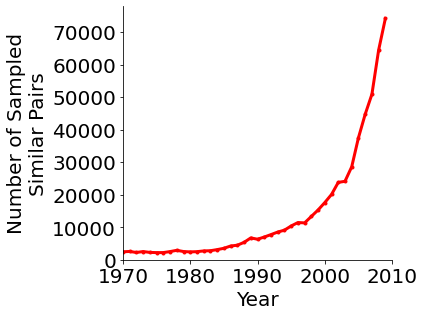

In [7]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

simp.plot(style='.-',color='red', lw=3)

plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1970, xmax=2010)
plt.xticks(np.arange(1970, 2011, 10), fontsize=20)
plt.ylabel('Number of Sampled\nSimilar Pairs', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0)

plt.tight_layout()
# fig.savefig(f"drive/My Drive/codes/SI_fig7.pdf")

In [12]:
simp = pd.DataFrame({'year':simp.index, 'count':simp.values})

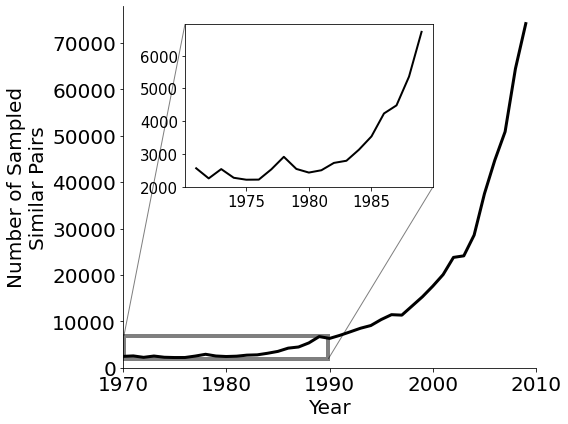

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plt.plot(simp['year'], simp['count'], color='black', lw=3)

inset_ax = ax.inset_axes([0.15, 0.5, 0.6, 0.45])
inset_ax.plot(simp['year'][52:71], simp['count'][52:71], color='black', lw=2)
inset_ax.tick_params(labelsize=15)

plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1970, xmax=2010)
plt.xticks(np.arange(1970, 2011, 10), fontsize=20)
plt.ylabel('Number of Sampled\nSimilar Pairs', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0)
ax.indicate_inset_zoom(inset_ax, edgecolor="black", linewidth = 4)

plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/simpairs_zoomed.pdf")

# Comparing similar m-m pairs and m-w pairs

## Percentile plots of centrality difference by year

In [34]:
# man-woman pairs

sim_mf = pd.read_csv("/Users/robinkong/codes/mfpairs_similarity.csv")

# apply year restriction

mfs = sim_mf[sim_mf['yeard'] <= 3]
mfs = mfs[mfs['yeard'] >= -3].reset_index(drop=True)

# label the publication year of pairs as the publication year of a latter one

lateryear = []

for i in tqdm(range(len(mfs))):
    lateryear.append(max(mfs['year1'][i], mfs['year2'][i]))

mfs['lateryear'] = lateryear

# apply similarity threshold

p = 0.001

simp = mfs[mfs['qval'] < p].sort_values('countd').reset_index(drop=True)
print(len(simp)/len(mfs))

simp = simp[['lateryear', 'countd']].sort_values(by=['lateryear', 'countd'])

100%|██████████| 5611686/5611686 [00:35<00:00, 157885.24it/s]


0.10213864425058708


In [35]:
# man-man pairs

sim_mm = pd.read_csv("/Users/robinkong/codes/mmpairs_similarity.csv")

# apply year restriction

mms = sim_mm[sim_mm['yeard'] <= 3]
mms = mms[mms['yeard'] >= -3].reset_index(drop=True)

# label the publication year of pairs as the publication year of a latter one

lateryear = []

for i in tqdm(range(len(mms))):
    lateryear.append(max(mms['year1'][i], mms['year2'][i]))

mms['lateryear'] = lateryear

# apply similarity threshold

p = 0.001

simp_mm = mms[mms['qval'] < p].sort_values('countd').reset_index(drop=True)
print(len(simp_mm)/len(mms))

simp_mm = simp_mm[['lateryear', 'countd']].sort_values(by=['lateryear', 'countd'])

100%|██████████| 19193545/19193545 [02:09<00:00, 148304.87it/s]


0.11612544738348231


In [37]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [38]:
# find the percentile statistics for m-w pairs

paired_mf = simp.groupby('lateryear').agg([np.mean, percentile(10), percentile(20),
                                      percentile(30), percentile(40), np.median,
                                      percentile(60), percentile(70), percentile(80),
                                      percentile(90)]).reset_index()

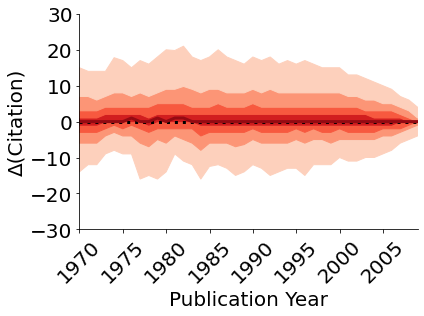

In [87]:
# m-w pair percentile plot

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

cm = sns.color_palette("Reds",10)

plt.axhline(y=0, color='black', linestyle='dotted', lw=3)
plt.plot(paired_mf.lateryear,paired_mf.countd["median"],"-",label="M-F Median", color=cm[9], lw=3)

plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_10"],
                 paired_mf.countd["percentile_20"], color=cm[1])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_20"],
                 paired_mf.countd["percentile_30"], color=cm[3])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_30"],
                 paired_mf.countd["percentile_40"], color=cm[5])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_40"],
                 paired_mf.countd["median"], color=cm[7])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["median"],
                 paired_mf.countd["percentile_60"], color=cm[7])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_60"],
                 paired_mf.countd["percentile_70"], color=cm[5])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_70"],
                 paired_mf.countd["percentile_80"], color=cm[3])
plt.fill_between(paired_mf.lateryear, paired_mf.countd["percentile_80"],
                 paired_mf.countd["percentile_90"], color=cm[1])

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.xlabel("Publication Year", fontsize=20)
plt.ylabel("\u0394(Citation)", fontsize=20)

plt.xlim(xmin=1970, xmax=2009)
plt.ylim(ymin=-30, ymax=30)

plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/mfpair_pp.pdf")

In [75]:
ref = simp.lateryear.unique()
numlist = []

mm_centrality = pd.DataFrame(columns=['lateryear'])

for num in ref:
    numlist.append(num)
mm_centrality['lateryear'] = numlist

# take the average of 100 random m-m pair samples per year and calculate the centrality difference

for k in tqdm(range(100)):
    df1 = pd.DataFrame(columns=['lateryear', 'countd'])
    vlist = []

    for i in range(len(ref)):
        df2 = simp_mm[simp_mm['lateryear'] == ref[i]].sample(
            simp.lateryear.value_counts().sort_index().iloc[i], replace=True)
        df1 = pd.concat([df1,df2])
    
    for j in range(len(new_df)):
        if randint(0,1) == 0:
            vlist.append(df1.countd.iloc[j])
        else:
            vlist.append(df1.countd.iloc[j] * -1)
    
    df1['value'] = vlist
    df1 = df1.groupby("lateryear").agg([np.mean]).reset_index().drop(['lateryear'], axis=1)

    mm_centrality = pd.concat([mm_centrality, df1], axis=1)

100%|██████████| 100/100 [08:03<00:00,  4.84s/it]


In [76]:
mm_centrality

,lateryear,"(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)",...,"(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)","(value, mean)"
0,1903,0.000000,1.333333,0.000000,1.333333,0.000000,0.000000,-0.666667,0.000000,0.000000,...,0.666667,0.666667,0.666667,0.000000,0.666667,-0.666667,0.000000,-1.333333,0.666667,-0.666667
1,1916,0.000000,1.000000,1.000000,1.000000,5.000000,-1.000000,-5.000000,0.000000,0.000000,...,-5.000000,-1.000000,0.000000,0.000000,9.000000,-5.000000,-6.000000,-9.000000,-4.000000,-1.000000
2,1918,1.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,-2.000000,...,0.000000,1.000000,-14.000000,0.000000,-11.000000,-2.000000,-1.000000,0.000000,1.000000,0.000000
3,1921,0.000000,1.000000,1.000000,-3.000000,0.000000,0.000000,-3.000000,0.000000,0.000000,...,-1.000000,-3.000000,-3.000000,-1.000000,2.000000,-3.000000,1.000000,2.000000,3.000000,-2.000000
4,1923,1.000000,1.500000,4.500000,0.000000,0.500000,1.000000,-6.000000,-14.500000,0.500000,...,0.000000,0.500000,0.500000,-4.000000,-0.500000,-9.500000,-8.500000,0.000000,-4.500000,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2005,0.076646,-0.013245,-0.018389,0.049143,0.010394,0.104603,-0.080591,-0.083869,-0.038696,...,-0.005677,0.066972,0.008501,0.088479,-0.061749,-0.066732,0.034326,-0.136743,-0.011060,-0.039363
87,2006,0.167065,-0.162214,0.041498,0.025824,0.042079,0.092879,0.082683,-0.090799,0.037295,...,-0.007803,-0.165746,-0.043466,-0.024237,-0.093639,-0.040939,-0.133169,0.163376,-0.039508,0.071683
88,2007,0.013874,0.016114,-0.061370,0.056909,-0.026450,0.021695,-0.028592,0.012773,-0.020889,...,0.026843,0.030773,-0.065733,-0.028946,-0.024544,-0.050680,-0.138834,-0.028907,0.054355,0.039341
89,2008,-0.027920,-0.001675,0.026430,-0.064696,-0.017124,0.005351,0.001303,-0.047960,-0.022692,...,-0.014177,0.022723,-0.061035,-0.025810,0.037567,0.027889,-0.016240,0.061997,0.029440,0.046812


In [78]:
# record the percentiles of the average statistics of 100 m-m pairs per year

paired_mm = mm_centrality.copy()

list_1, list_2, list_3, list_4, list_5, list_6, list_7, list_8, list_9 = [], [], [], [], [], [], [], [], []

for i in range(len(paired_mm)):
    list_1.append(np.percentile(paired_mm.iloc[i,1:],10))
    list_2.append(np.percentile(paired_mm.iloc[i,1:],20))
    list_3.append(np.percentile(paired_mm.iloc[i,1:],30))
    list_4.append(np.percentile(paired_mm.iloc[i,1:],40))
    list_5.append(np.median(paired_mm.iloc[i,1:]))
    list_6.append(np.percentile(paired_mm.iloc[i,1:],60))
    list_7.append(np.percentile(paired_mm.iloc[i,1:],70))
    list_8.append(np.percentile(paired_mm.iloc[i,1:],80))
    list_9.append(np.percentile(paired_mm.iloc[i,1:],90))

paired_mm['percentile_10'] = list_1
paired_mm['percentile_20'] = list_2
paired_mm['percentile_30'] = list_3
paired_mm['percentile_40'] = list_4
paired_mm['median'] = list_5
paired_mm['percentile_60'] = list_6
paired_mm['percentile_70'] = list_7
paired_mm['percentile_80'] = list_8
paired_mm['percentile_90'] = list_9

paired_mm = paired_mm[['lateryear', 'percentile_10','percentile_20','percentile_30',
                       'percentile_40','median','percentile_60','percentile_70',
                       'percentile_80','percentile_90']]

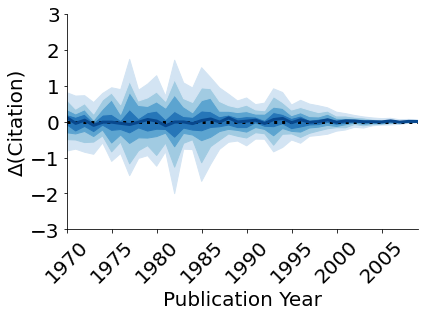

In [89]:
# m-m averaged percentile plot

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

cm2 = sns.color_palette("Blues",10)

plt.axhline(y=0, color='black', linestyle='dotted', lw=3)
plt.plot(paired_mm.lateryear,paired_mm["median"],"-",label="M-M Median", color=cm2[9], lw=3)

plt.fill_between(paired_mm.lateryear, paired_mm["percentile_10"],
                 paired_mm["percentile_20"], color=cm2[1])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_20"],
                 paired_mm["percentile_30"], color=cm2[3])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_30"],
                 paired_mm["percentile_40"], color=cm2[5])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_40"],
                 paired_mm["median"], color=cm2[7])
plt.fill_between(paired_mm.lateryear, paired_mm["median"],
                 paired_mm["percentile_60"], color=cm2[7])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_60"],
                 paired_mm["percentile_70"], color=cm2[5])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_70"],
                 paired_mm["percentile_80"], color=cm2[3])
plt.fill_between(paired_mm.lateryear, paired_mm["percentile_80"],
                 paired_mm["percentile_90"], color=cm2[1])

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.xlabel("Publication Year", fontsize=20)
plt.ylabel("\u0394(Citation)", fontsize=20)

plt.xlim(xmin=1970, xmax=2009)
plt.ylim(ymin=-3, ymax=3)

plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/mmpair_pp.pdf")

## Centrality differences of similar m-m & m-f pairs by year

In [123]:
# mm_ms is the DataFrame for the difference plot (M-M pairs)
mm_ms = mm_centrality.copy()

# Retrieving the list of means and SDs
meanlist = mm_ms.iloc[:,1:].mean(axis=1).tolist()
sdlist = mm_ms.iloc[:,1:].std(axis=1).tolist()

# Appending to the DataFrame
mm_ms['avg'] = meanlist
mm_ms['sd'] = sdlist
mm_ms = mm_ms[['lateryear','avg','sd']]

In [124]:
# mf_ms is the DataFrame for the difference plot (M-F pairs)
mf_ms = simp.groupby("lateryear").agg(['count', np.mean, np.std]).reset_index()

# Retrieve a standard error list for M-F pairs
semlist = []

for i in range(len(mf_ms)):
    semlist.append(mf_ms.countd['std'][i]/math.sqrt(mf_ms.countd['count'][i]))

mf_ms['sem'] = semlist

In [125]:
# remove sparse year data (not used in visualization regardlessly)

mm_ms = mm_ms.loc[4:].reset_index(drop=True)
mf_ms = mf_ms.loc[4:].reset_index(drop=True)

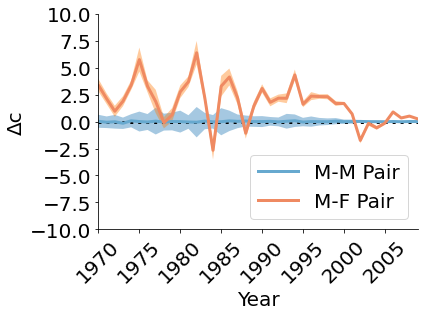

In [129]:
# Creating a year vs. centrality difference plot, separated by gender

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# Equilibrium line
plt.axhline(y=0, color='black', linestyle='dotted', lw=3)

# Plotting M-M pairs
plt.plot(mm_ms.lateryear,mm_ms.avg,"-",label="M-M Pair",
         color='#67a9cf', lw=3)

# shading the SD area (M-M)
X  = np.linspace(min(mm_ms.lateryear),max(mm_ms.lateryear),mm_ms.lateryear.nunique())
plt.fill_between(X,
                 mm_ms.avg + mm_ms.sd,
                 mm_ms.avg - mm_ms.sd,
                 color='C0',alpha=.4,edgecolor="none")

# Plotting M-F pairs
plt.plot(mf_ms.lateryear,mf_ms.countd['mean'],"-",label="M-F Pair",
         color='#ef8a62', lw=3)

# shading the SE area (M-F)
plt.fill_between(X,
                 mf_ms.countd['mean'] + mf_ms['sem'],
                 mf_ms.countd['mean'] - mf_ms['sem'],
                 color='C1',alpha=.4,edgecolor="none")

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.xlabel("Year",fontsize=20)
plt.ylabel("\u0394c",fontsize=20)
plt.xlim(xmin=1970, xmax=2009)
plt.ylim(ymin=-10, ymax=10)

plt.legend(loc='lower right', fontsize=20)

plt.tight_layout()
fig.savefig(f"/Users/robinkong/codes/mm_mf_cdiff.pdf")